In [28]:
from typing import Dict

from EPMSim.MethylationSite.SiteGenerator import SiteGenerator
from EPMSim.MethylationSite.ValueGenerator import generate_sample_methylation
from EPMSim.Simulate.SimulateSamples import simulate_samples
from EPMSim.Sample import Sample
from EPMSim.Phenotype import BinaryPhenotype, ContinuousPhenotype, construct_age_association
from EPMSim.Simulate.SimulateSites import GenerateSites

from EpigeneticPacemaker.EpigeneticPacemaker import EpigeneticPacemaker
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy import optimize
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from EpigeneticPacemaker import EpigeneticPacemaker

In [3]:
default_age_assoc, default_repr = construct_age_association(return_repr=True)

## Test Phenotype Simulation

In [4]:
linear_age_association, linear_age_repr = construct_age_association(age_weight=.2, age_exponent=1, return_repr=True)
strong_age_association, strong_age_repr = construct_age_association(age_weight=.5, age_exponent=.8, return_repr=True)
stronger_age_association, stronger_age_repr = construct_age_association(age_weight=1, age_exponent=.5, return_repr=True)
sqrt_age_association, sqrt_age_repr = construct_age_association(age_weight=.2, age_exponent=0.5, return_repr=True)

$p_a = 0.20\times a^{ 0.50}\times p$

In [5]:
binary_increasing = BinaryPhenotype(mean=.2, std=0.1, binary_prob=0.2, age_limit=15, age_association=linear_age_association,
                                    representation='binary_increasing_linear', age_repr=linear_age_repr)

In [6]:
binary_increasing_2 = BinaryPhenotype(mean=.1, std=0.1, binary_prob=0.6, age_limit=16, age_association=linear_age_association,
                                    representation='binary_increasing_linear_2', age_repr=linear_age_repr)

In [7]:
binary_categorical_decreasing = BinaryPhenotype(mean=-.2, std=0.0, binary_prob=0.5, age_association=linear_age_association,
                                                representation='binary_categorical_decreasing_liner', age_repr=linear_age_repr)

In [8]:
continuous_age_only = ContinuousPhenotype(mean=1.0, std=0.01, age_association=stronger_age_association,
                                          representation='continuous_age_only', age_repr=stronger_age_repr,
                                          health_effect=False)

In [9]:
continuous_mixed = ContinuousPhenotype(mean=0.0, std=.1, age_association=sqrt_age_association,
                                       representation='continuous_mixed', age_repr=sqrt_age_association)

In [10]:
continuous_mixed_2 = ContinuousPhenotype(mean=0.0, std=.2, age_association=strong_age_association,
                                       representation='continuous_mixed_2', age_repr=strong_age_repr)

In [11]:
continuous_age_associated_no_health = ContinuousPhenotype(mean=0.0, std=.2, age_association=strong_age_association,
                                                          representation='continuous_age_associated_no_health',
                                                          age_repr=strong_age_repr, health_effect=False)

In [12]:
continuous_random = ContinuousPhenotype(mean=0.0, std=.1, health_effect=False,
                                        representation='continuous_random_1')

In [13]:
continuous_random_2 = ContinuousPhenotype(mean=0.0, std=.2, health_effect=False,
                                        representation='continuous_random_2')

In [14]:
test_phenotypes = [binary_increasing, binary_increasing_2, binary_categorical_decreasing, continuous_mixed,
                   continuous_mixed_2, continuous_random, continuous_random_2, continuous_age_associated_no_health, 
                   continuous_age_only]

In [15]:
samples = simulate_samples(phenotypes=test_phenotypes)

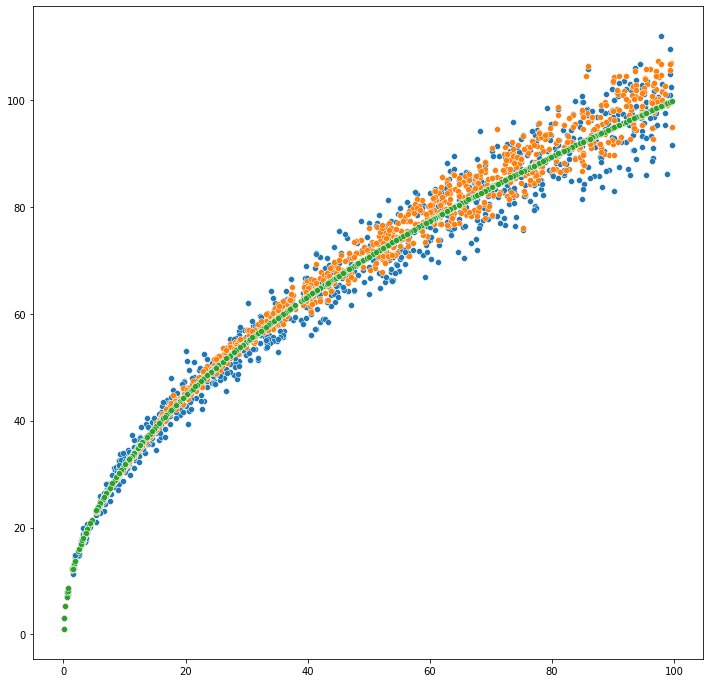

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(x=[sample.age for sample in samples.values()], y=[(10.0 * sample.age**0.5 * (1 + sample.health)) for sample in samples.values()], ax=ax)
sns.scatterplot(x=[sample.age for sample in samples.values()], y=[sample.epigenetic_state for sample in samples.values()], ax=ax)
sns.scatterplot(x=[sample.age for sample in samples.values()], y=[sample.expected_epigenetic_state for sample in samples.values()], ax=ax)


plt.show()

### Simulate Methylation Matrix

In [17]:
sim_sim_weights = {str(pheno):1.0 for pheno in test_phenotypes}
sim_sim_conditions = {count:[[str(pheno)], 50] for count, pheno in enumerate(test_phenotypes)}

In [18]:
site_gen = GenerateSites(phenotype_weights=sim_sim_weights,
                         site_conditions=sim_sim_conditions,
                         noise_sites=3000)

In [19]:
site_info, meth_values, meth_errors = site_gen.generate_matrix(samples)

## Fit EPM

In [20]:
ages = np.array([sample.age for sample in samples.values()])

In [21]:
train_x, test_x, train_y, test_y = train_test_split(meth_values.T, ages)

In [22]:
def pearson_correlation(meth_matrix: np.array, phenotype: np.array) -> np.array:
    """calculate pearson correlation coefficient between rows of input matrix and phenotype"""
    # calculate mean for each row and phenotype mean
    matrix_means = np.mean(meth_matrix, axis=1)
    phenotype_mean = np.mean(phenotype)

    # subtract means from observed values
    transformed_matrix = meth_matrix - matrix_means.reshape([-1,1])
    transformed_phenotype = phenotype - phenotype_mean

    # calculate covariance
    covariance = np.sum(transformed_matrix * transformed_phenotype, axis=1)
    variance_meth = np.sqrt(np.sum(transformed_matrix ** 2, axis=1))
    variance_phenotype = np.sqrt(np.sum(transformed_phenotype ** 2))

    return covariance / (variance_meth * variance_phenotype)

In [38]:
# get the absolute value of the correlation coefficient
abs_pcc_coefficients = abs(pearson_correlation(train_x.T, train_y))

# return list of site indices with a high absolute correlation coefficient
training_sites = np.where(abs_pcc_coefficients > .4)[0]

In [39]:
# use latex formatting for plots
rc('text', usetex=True)

In [40]:
def r2(x, y):
    # return r squared
    return stats.pearsonr(x, y)[0] ** 2

In [41]:
def plot_known_predicted_ages(known_ages, predicted_ages, label=None):
    # define optimization function
    def func(x, a, b, c):
        return a * np.asarray(x)**0.5 + c
    # fit trend line
    popt, pcov = optimize.curve_fit(func, [1 + x for x in known_ages], predicted_ages)
    # get r squared
    rsquared = r2(predicted_ages, func([1 + x for x in known_ages], *popt))
    # format plot label
    plot_label = f'$f(x)={popt[0]:.2f}x^{{1/2}} {popt[2]:.2f}, R^{{2}}={rsquared:.2f}$'
    # initialize plt plot
    fig, ax = plt.subplots(figsize=(12,12))
    # plot trend line
    ax.plot(sorted(known_ages), func(sorted([1 + x for x in known_ages]), *popt), 'r--', label=plot_label)
    # scatter plot
    ax.scatter(known_ages, predicted_ages, marker='o', alpha=0.8, color='k')
    ax.set_title(label, fontsize=18)
    ax.set_xlabel('Chronological Age', fontsize=16)
    ax.set_ylabel('Epigenetic State', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
    plt.show()

In [42]:
# initialize the EPM model
epm = EpigeneticPacemaker(iter_limit=100, error_tolerance=0.00001)

/home/colin/.pyenv/versions/3.8.0/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


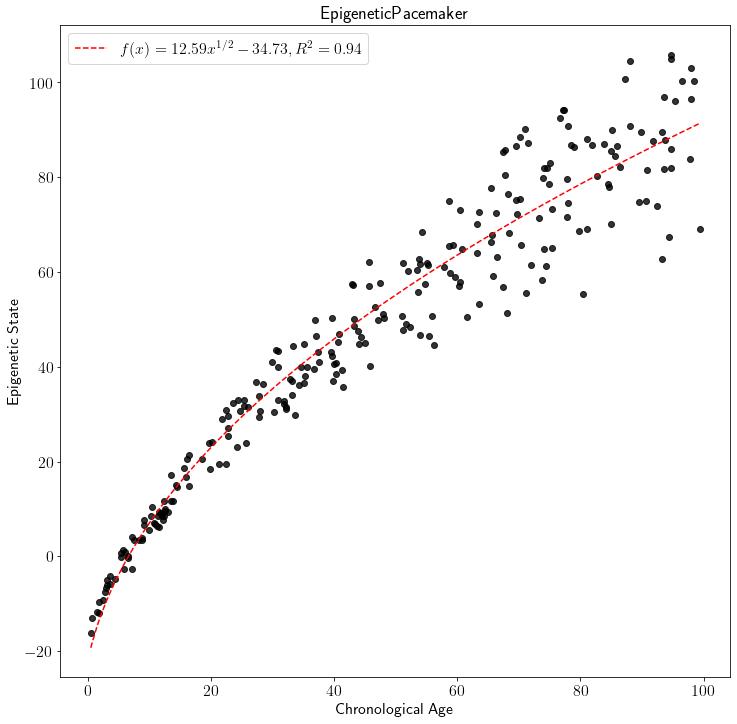

In [43]:
# fit the model using the training data
epm.fit(train_x.T[training_sites, :], train_y)

# generate predicted ages using the test data
test_predict = epm.predict(test_x.T[training_sites, :])

# plot the model results
plot_known_predicted_ages(test_y, test_predict, 'EpigeneticPacemaker')